# Intro a Series Temporales

Las series temporales son secuencias de números ordenadas por un indice de tiempo, es decir, una lista de valores ordenados. Pueden ser `univariadas`, solo un valor por timestamp:

|timestamp|value|
|:---------:|:-----:|
|09:00|1|
|10:00|2|
|11:00|4|
|12:00|2|
|13:00|1|
|14:00|2|
|15:00|4|
|16:00|2|

o `multivariadas`, donde recolectamos más de un dato/observación por timestamp.

|timestamp|pressure_mmhg|temperature_deg_C|wind_knots|
|:---------:|:-----:|:----:|:----:|
|09:00|720|28|15|
|10:00|730|29|16|
|11:00|725|29|14|


La predicción de series temporales presenta sus propios retos. El objetivo del analisis de las series temporales es ser capaz de aprovechar la naturaleza temporal del dato para poder realizar predicciones. Es decir, intentaremos aprovechar características como la tendencia y la estacionalidad para realizar modelos predictivos.

![decomposition](img/ts-decomposition.png)

La forma tradicional de tratar un problema de predicción de serie temporal es utilizando modelos autoregresivos (See [ARIMA](https://people.duke.edu/~rnau/411arim.htm) models). Es decir, basar una predicción en un momento `t` como una regresión basada en los valores de `t-1`a `t-n`. A los valores pasado los llamaremos `lags`. Por ejemplo,

$y_t = \theta \times y_{t-1} + C$

La expresión de arriba se puede ampliar con más lags, pero por lo general, el proceso de predicción de una serie temporal se basa en:

1. Graficar la serie temporal, y descomponer en tendencia, estacionalidad y ruido.
2. Modelizar la tendencia: $y_t = \theta \times t + C$
3. Modelizar la componente estacional $ y_t = \alpha \sin(\omega t) $
3. Modelizar los residuos: $\varepsilon \sim N(0, \sigma^2)$
4. Sumar todas las componentes modelizadas

## ML aplicado a Series temporales

Recordemos que de forma genereal, un problema de ML supervisado se entiende como una funcion que mapea unas variables de entrada X, a una salida y:

$\hat{y} = h(X)$

¿Cómo podríamos aunar los dos mundos? Basandonos en la idea general del modelo de AutoRegresion, podemos generarnos las features X de forma que podamos afrontar un problema de predicción de serie temporal como un problema de regresión supervisado.

Dada una secuencia de números, podemos usar los datos de momentos anteriores como variables de entrada como valor de predicción. Si miramos el ejemplo anterior, podemos convertirlo en:


|timestamp|value_t-2|value_t-1|value|
|:---------:|:-----:|:----:|:----:|
|09:00|NaN|NaN|1|
|10:00|NaN|1|2|
|11:00|1|2|4|
|12:00|2|4|2|
|13:00|4|2|1|
|14:00|2|1|2|
|15:00|1|2|4|
|16:00|2|4|2|


De esta forma, podemos usar los valores `lags` como input para predecir el valor en tiempo `t`.



## Validación cruzada para series temporales

Sabemos que la apliación de algoritmos de ML implica encontrar el mejor balance entre error de bies y error de varianza. En un caso normal, esto se consigue mediante validación crruzada en la que ejemplos del dataset de entrenamiento son seleccionados aleatoriamente como subset de validación, sobre el que estimaremos el rendimiento de nuestro modelo.

En series temporales, tenemos un caso distinto. El problema que queremos resolver es predecir un valor en el futuro, por lo que el subset de `validación` **siempre tendra que ocurrrir despues** del subset de entrenamiento. De forma intuitiva, piensa que no deberíamos predecir el tiempo que va a hacer mañana usando como variable el tiempo que va a hacer pasado mañana.

En general:

- Nuestro subset de testeo debe ocurrir despues de nuestro subset de entrenamiento.
- No podemos coger datapoints de forma aleatoria ya que tendremos variables que son indicadores de lag que pueden filtrarnos informacion. Esto nos fuerza a trabajar con bloques de tiempo contiguos.

La figura de abajo muestra patrones comunes de train - test:

![ts cross-validation illustration](img/cv-ts.png)


## Ventajas de usar ML para series temporales

- Familiaridad de los algoritmos de regresion: regresion lineal, ensemble tree models, redes neuronales...
- Optimizacion de hiperparapetros
- Incluir features adicionales que nos aporten información contextual: temperatura, si es fin de semana, ...

Nota final:

Para las series temporales `facebook` publicó recientemente [prophet](https://facebook.github.io/prophet/docs/quick_start.html#python-api.). El way to go para hacer una prueba rapida.

1. Carga las librerías as usual

In [1]:
%matplotlib inline
import matplotlib
import seaborn as sns
import warnings

In [2]:
warnings.filterwarnings('ignore')

In [3]:
import numpy as np
import scipy as sp
import pandas as pd
from sklearn.linear_model import LinearRegression 
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
from ipywidgets import interact

In [4]:
sns.set_style('darkgrid')

2. Cargamos los datos en un df

El dataset representa el uso de bicicletas compartidas (`cnt`) en un día en función del día y de las variables ambientales de ese dia.

In [5]:
df = pd.read_csv('data/bike-share.csv')

In [6]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600


3. Convierte el campo `dteday` tipo `datetime`.

pandas tiene una utilidad para ello...`pd.to_datetime()`

In [7]:
df['dteday'] = pd.to_datetime(df['dteday'])

4. Vamos a empezar visualizando nuestra serie temporal

<AxesSubplot:xlabel='dteday'>

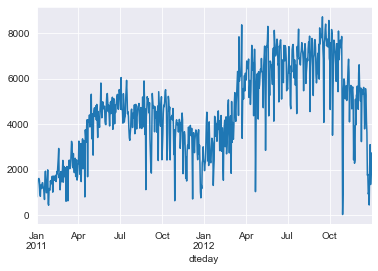

In [8]:
df.set_index('dteday')['cnt'].plot()

5. Vamos a crear nuevas variables que reflejen la dependencia temporal:

* Los tres ultimos lags

In [9]:
def create_lags(df, field, n_lags):
    for lag in range(1, n_lags+1):
        df[field + f'_t-{str(lag)}'] = df[field].shift(lag)
    return df

In [10]:
df = create_lags(df, 'cnt', 3)

In [11]:
df.head()

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_t-1,cnt_t-2,cnt_t-3
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,NaN,NaN,NaN
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,985.0,NaN,NaN
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,801.0,985.0,NaN
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,1349.0,801.0,985.0
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,1562.0,1349.0,801.0


* La media móvil de los ultimos 7 días

In [12]:
def moving_average(df, field, n_lags):
    df[f'mvng_avg_{field}_{n_lags}'] = df[field].rolling(window=n_lags).mean()
    return df

In [13]:
df = moving_average(df, 'cnt', 7)

In [14]:
df.head(10)

,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,cnt_t-1,cnt_t-2,cnt_t-3,mvng_avg_cnt_7
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,NaN,NaN,NaN,NaN
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,985.0,NaN,NaN,NaN
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,801.0,985.0,NaN,NaN
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,1349.0,801.0,985.0,NaN
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,1562.0,1349.0,801.0,NaN
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606,1600.0,1562.0,1349.0,NaN
6,7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510,1606.0,1600.0,1562.0,1344.714286
7,8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959,1510.0,1606.0,1600.0,1341.000000
8,9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822,959.0,1510.0,1606.0,1344.000000
9,10,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321,822.0,959.0,1510.0,1340.000000


<AxesSubplot:xlabel='dteday'>

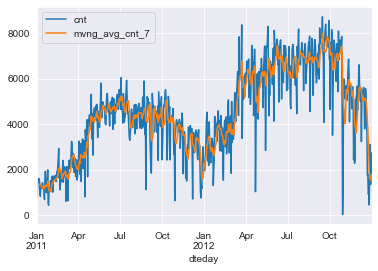

In [15]:
df.set_index('dteday')[['cnt', 'mvng_avg_cnt_7']].plot()

* La media movil de los 7 días anteriores de hace un año de la fecha de hoy

In [16]:
df['last_year_date'] = df['dteday'] - pd.offsets.DateOffset(years=1)
df = df.rename(columns={'last_year_date': 'to_cross'}).merge(
    df[['dteday', 'mvng_avg_cnt_7']].rename(columns={'dteday': 'to_cross'}),
    on='to_cross',
    suffixes=['_cy', '_ly'],
    how='left')

Let's check is well calculated

In [17]:
day_cy = '2012-12-28'
day_ly = '2011-12-28'

display(df[df['dteday'] == day_cy][['dteday', 'mvng_avg_cnt_7_cy', 'mvng_avg_cnt_7_ly']])
display((df[df['dteday'] == day_ly][['dteday', 'mvng_avg_cnt_7_cy', 'mvng_avg_cnt_7_ly']]))

,dteday,mvng_avg_cnt_7_cy,mvng_avg_cnt_7_ly
727,2012-12-28,1588.428571,1689.0


,dteday,mvng_avg_cnt_7_cy,mvng_avg_cnt_7_ly
361,2011-12-28,1689.0,NaN


ok!

<AxesSubplot:xlabel='dteday'>

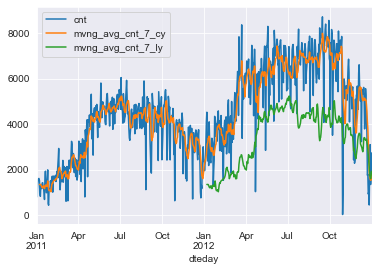

In [18]:
df.set_index('dteday')[['cnt', 'mvng_avg_cnt_7_cy', 'mvng_avg_cnt_7_ly']].plot()

* The ratio between the moving average of last year wrt current year

In [19]:
df['increase_wrt_ly'] = df['mvng_avg_cnt_7_cy'] / df['mvng_avg_cnt_7_ly']

In [20]:
df['increase_wrt_ly'].describe()

count    360.000000
mean       1.777119
std        0.495862
min        0.895722
25%        1.438219
50%        1.610444
75%        2.023913
max        3.842576
Name: increase_wrt_ly, dtype: float64

<AxesSubplot:>

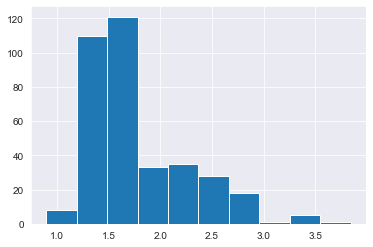

In [21]:
df['increase_wrt_ly'].hist()

**Parece que la demanda ha crecido entre un 60% - 70%**

#### Modelización

In [22]:
from sklearn.model_selection import TimeSeriesSplit

In [23]:
ts_cv = TimeSeriesSplit(n_splits=5,
                        gap=2, # leave 2 days out between train and test
                        test_size=100)


In [24]:
all_splits = list(ts_cv.split(df))

Let's check the initial splits

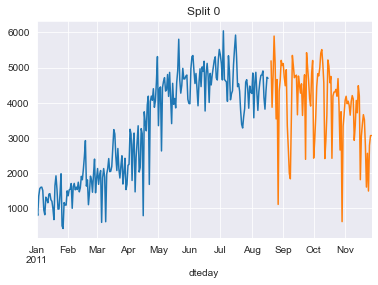

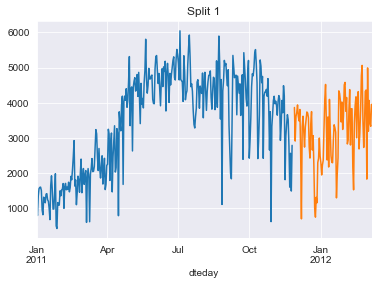

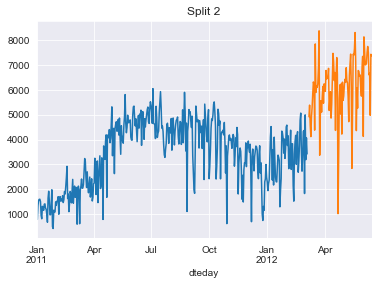

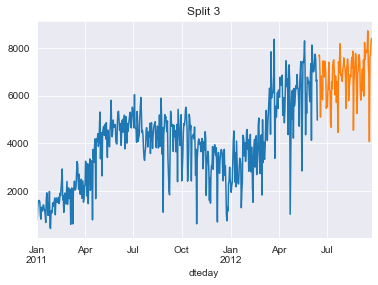

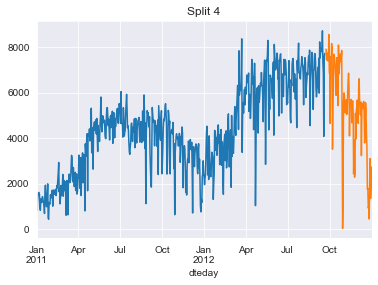

In [25]:
for ix, split in enumerate(all_splits):
    train_indexes = split[0]
    test_indexes = split[1]
    df.iloc[train_indexes].set_index('dteday')['cnt'].plot()
    df.iloc[test_indexes].set_index('dteday')['cnt'].plot()
    plt.title(f'Split {ix}')
    plt.show()

## Vamos a entrenar un modelo para ver como se comportat

In [26]:
from sklearn.ensemble import RandomForestRegressor

In [27]:
X_columns = ['season', 'yr', 'mnth', 'holiday', 'weekday',
             'workingday', 'weathersit', 'temp', 'atemp', 'hum',
             'windspeed','cnt_t-1', 'cnt_t-2',
             'cnt_t-3', 'mvng_avg_cnt_7_cy', 'increase_wrt_ly']
y_col = 'cnt'

In [28]:
X = df[X_columns]
y = df[y_col]

OJO: No incluimos la media movil del año pasado por que nos va a introducir muchos nulos y es dificil de imputar. Hemos visto que el crecimiento de este año ha sido del ~60%. Podemos hacer varias pruebas y ver que pasa si imputamos el campo `increase_wrt_ly` con ese 60% o asumimos que no hubo crecimiento con respecto al año pasado (imputar 1). Asumiremos este ultimo caso a falta de datos por ser más conservador

In [29]:
X['increase_wrt_ly'] = X['increase_wrt_ly'].fillna(1)

La media movil no sé puede calcular para los primeros 6 lags. Vamos a imputar con el primer valor.

In [30]:
X['mvng_avg_cnt_7_cy'] = X['mvng_avg_cnt_7_cy'].fillna(method='bfill')

In [31]:
X[['cnt_t-1', 'cnt_t-2', 'cnt_t-3']] = X[['cnt_t-1', 'cnt_t-2', 'cnt_t-3']].fillna(-1)

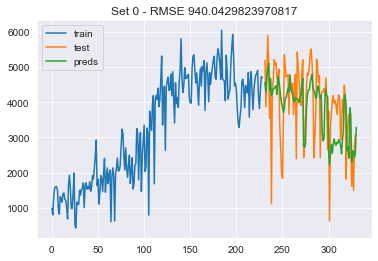

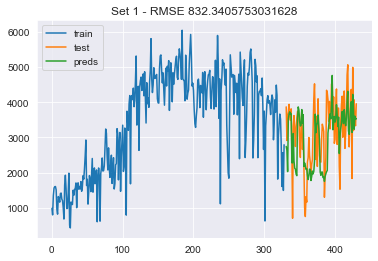

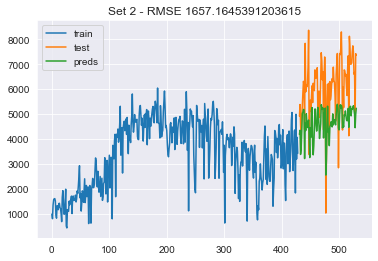

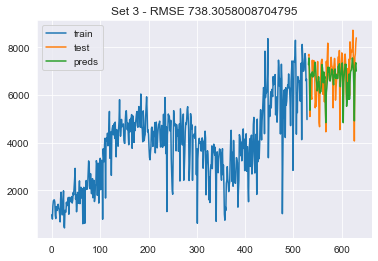

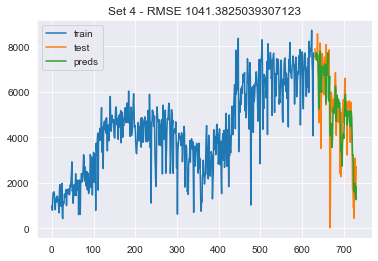

In [32]:
scores = []

for ix, (train_index, test_index) in enumerate(all_splits):

    data_train   = X.iloc[train_index]
    target_train = y.iloc[train_index]

    data_test    = X.iloc[test_index]
    target_test  = y.iloc[test_index]

    reg = RandomForestRegressor()
    reg.fit(data_train, target_train)

    preds = reg.predict(data_test)

    # accuracy for the current fold only    
    rmse = np.sqrt(mean_squared_error(target_test,preds))

    scores.append(rmse)
    plt.title(f'Set {ix} - RMSE {rmse}')
    plt.plot(train_index, target_train, label='train')
    plt.plot(test_index, target_test, label='test')
    plt.plot(test_index, preds, label='preds')
    plt.legend()
    plt.show()

# this is the average accuracy over all folds
average_score = np.mean(scores)

In [33]:
average_score

1041.8472803243596

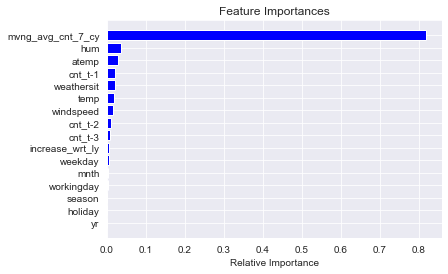

In [34]:
features = X.columns
importances = reg.feature_importances_
indices = np.argsort(importances)

plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

Inspeccionando el Random Forest vemos que la variable más importante es la media movil de la semana y entre las más importantes las features de `lag`

## Exit Points

Crear variables de series temporales puede ser tedioso y complicado.

Existen librerias que nos ayudan a trabajar con series temporales:

* [sktime](https://github.com/alan-turing-institute/sktime): A sklearn type library for TS
* [tsfresh](https://tsfresh.readthedocs.io/en/latest/): Automatically calculates a large number of time series characteristics, the so called features.